In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Getting the Data
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [4]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
print('중앙값 : ', session_length.median()) # Median 96.0
print('평균값 : ', session_length.mean()) # Mean 165.599
print('최솟값 : ', session_length.min()) # Min 20
print('최댓값 : ', session_length.max()) # Max 2314

중앙값 :  96.0
평균값 :  165.5975165562914
최솟값 :  20
최댓값 :  2314


In [6]:
session_length.quantile(0.999) 

1343.181000000005

In [7]:
# 가장 많이 남긴 유저 체크
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [8]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

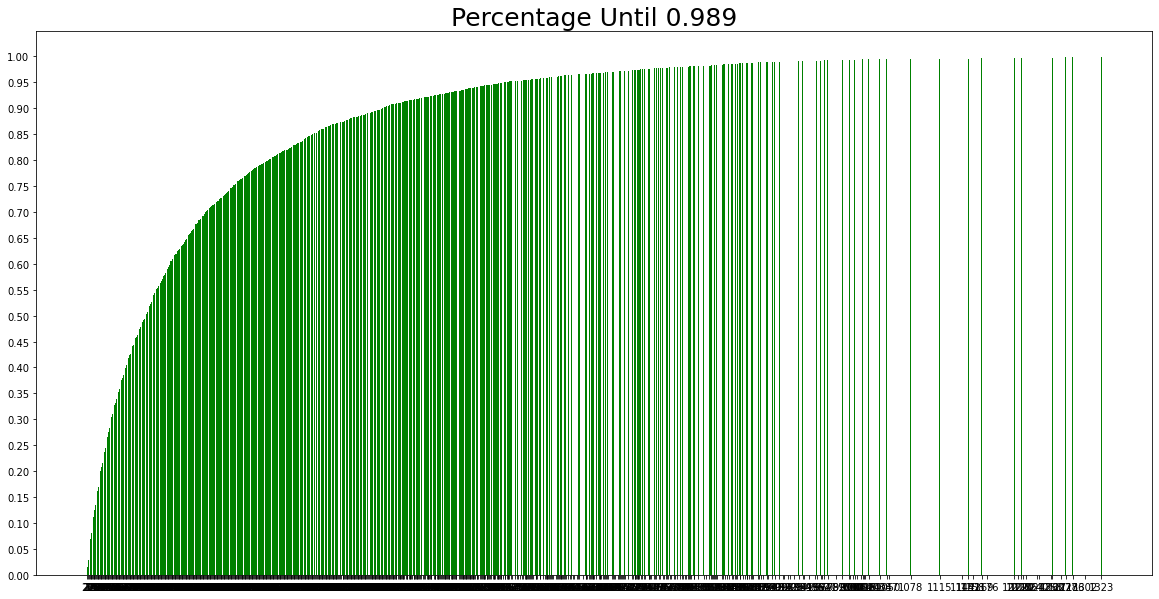

In [9]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index, height=length_percent_cumsum_999, color='green')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Percentage Until 0.989', size=25)
plt.show()

#생각 보다 결과 차이가 많이 나네요.

In [10]:
# test
before = data.loc[31]['Time']
after = pd.to_datetime(before, unit='s')
print(before, after)

data['Time'] = pd.to_datetime(data['Time'], unit='s')
data

978300019 2000-12-31 22:00:19


,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [23]:
oldset, latest = data['Time'].min(), data['Time'].max()
oldset, latest

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

In [24]:
month_ago = latest - dt.timedelta(30)
len(data[data['Time'] > month_ago])

1551

In [25]:
#Cleaning
item_length = data.groupby('ItemId').size()
item_length.head()

ItemId
1    2077
2     701
3     478
4     170
5     296
dtype: int64

In [26]:
item_length.min(), item_length.max(), item_length.mean(), item_length.median()

(1, 3428, 269.88909875876953, 123.5)

In [27]:
print(item_length.quantile(0.999)) # 99.9% 아이템의 길이는 2734이하
print(item_length.quantile(0.90))  # 90.0% 아이템의 길이는 729이하
print(item_length.quantile(0.75))  # 75.0% 아이템의 길이는 350이하

2734.2450000001113
729.5
350.0


In [28]:
item_use = item_length[item_length >= 269].index  # 평균 이상인 경우의 item index
print('평균(269)이상인 item 개수 : ', len(item_use))
print('before : ', len(data))
data = data[data['ItemId'].isin(item_use)]
print('after : ', len(data))

평균(269)이상인 item 개수 :  1151
before :  1000209
after :  792007


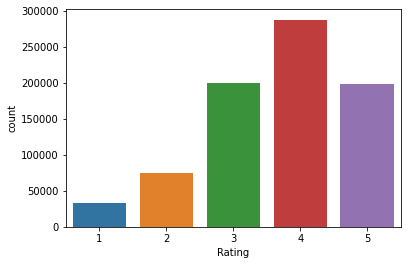

In [30]:
# rating마다 빈도수 시각화
sns.countplot(x='Rating', data=data)
plt.show()

In [31]:
rating_3 = len(data[data['Rating'] > 2])
print('rating이 3이상인 data 개수 : ', rating_3)
print('rating이 3이상인 data 퍼센트 : ', (rating_3/len(data))*100)

rating이 3이상인 data 개수 :  685145
rating이 3이상인 data 퍼센트 :  86.50744248472552


In [32]:
print('before data length : ', len(data))
data = data[data['Rating'] > 2]
print('after data length : ', len(data))

before data length :  792007
after data length :  685145


In [33]:
data['Time'].max() - data['Time'].min()

Timedelta('1038 days 18:43:36')

In [34]:
latest = data['Time'].max()
test_days = latest - dt.timedelta(15)
valid_days = test_days - dt.timedelta(100)
test_days, valid_days

(Timestamp('2003-02-13 17:49:08'), Timestamp('2002-11-05 17:49:08'))

In [36]:
train_data = data[data['Time'] < valid_days]
test_data = data[data['Time'] > test_days]

temp_data = data[data['Time'] >= valid_days]
valid_data = temp_data[temp_data['Time'] < test_days]

In [37]:
# data에 대한 정보 출력 함수
def stats_info(data, status):
    print(
        f'* {status} Set Stats Info\n'
        f'\t Events: {len(data)}\n'
        f'\t Sessions: {data["UserId"].nunique()}\n'
        f'\t Items: {data["ItemId"].nunique()}\n'
        f'\t First Time : {data["Time"].min()}\n'
        f'\t Last Time : {data["Time"].max()}\n'
    )

In [38]:
stats_info(train_data, 'train')
stats_info(valid_data, 'valid')
stats_info(test_data, 'test')

* train Set Stats Info
	 Events: 681404
	 Sessions: 6037
	 Items: 1151
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-11-05 06:15:50

* valid Set Stats Info
	 Events: 3318
	 Sessions: 233
	 Items: 968
	 First Time : 2002-11-05 18:16:04
	 Last Time : 2003-02-13 16:36:54

* test Set Stats Info
	 Events: 423
	 Sessions: 53
	 Items: 330
	 First Time : 2003-02-13 18:06:30
	 Last Time : 2003-02-28 17:49:08



In [39]:

# train set에 없는 아이템이 val, test!
id2idx = {item_id : index for index, item_id in enumerate(train_data['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train_data = indexing(train_data, id2idx)
valid_data = indexing(valid_data, id2idx)
test_data = indexing(test_data, id2idx)

In [40]:
# data 저장
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train_data.to_pickle(save_path / 'train.pkl')
valid_data.to_pickle(save_path / 'valid.pkl')
test_data.to_pickle(save_path / 'test.pkl')

In [41]:
#SessionDataSet 
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [42]:
tr_dataset = SessionDataset(train_data)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
3,1,3408,4,2000-12-31 22:04:35,5
7,1,2804,5,2000-12-31 22:11:59,6
47,1,1207,4,2000-12-31 22:11:59,7
0,1,1193,5,2000-12-31 22:12:40,8
21,1,720,3,2000-12-31 22:12:40,9


In [44]:
# click_offsets : 각 세션이 시작된 인덱스를 담고 있음
tr_dataset.click_offsets

array([     0,     50,    156, ..., 681099, 681193, 681404], dtype=int32)

In [45]:
# session_idx : 각 세션을 인덱싱한 np.array
tr_dataset.session_idx

array([   0,    1,    2, ..., 6034, 6035, 6036])

In [46]:
#SessionDataLoader 
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [47]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)


,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
3,1,3408,4,2000-12-31 22:04:35,5
7,1,2804,5,2000-12-31 22:11:59,6
47,1,1207,4,2000-12-31 22:11:59,7
0,1,1193,5,2000-12-31 22:12:40,8
21,1,720,3,2000-12-31 22:12:40,9


In [49]:
iter_ex = iter(tr_data_loader)

In [50]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 50 59 51]
Label Item Idx are :       [ 1 51 57 22]
Previous Masked Input Idx are []


In [51]:

def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [52]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [53]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [55]:
args = Args(train_data, valid_data, test_data, batch_size=20, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(20, 1, 1151)]           0         
_________________________________________________________________
GRU (GRU)                    [(20, 50), (20, 50)]      180450    
_________________________________________________________________
dropout_1 (Dropout)          (20, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (20, 1151)                58701     
Total params: 239,151
Trainable params: 239,151
Non-trainable params: 0
_________________________________________________________________


In [56]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [57]:
train_model(model, args)

Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0, train_loss=4.97]   

	 - Recall@20 epoch 1: 0.190254
	 - MRR@20    epoch 1: 0.053041



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0.05, train_loss=4.97]

	 - Recall@20 epoch 2: 0.196610
	 - MRR@20    epoch 2: 0.056950



Evaluation:  77%|███████▋  | 118/154 [00:16<00:05,  7.00it/s]

	 - Recall@20 epoch 3: 0.196610
	 - MRR@20    epoch 3: 0.058392



In [58]:
args1 = Args(train_data, valid_data, test_data, batch_size=20, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model1 = create_model(args1)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(20, 1, 1151)]           0         
_________________________________________________________________
GRU (GRU)                    [(20, 50), (20, 50)]      180450    
_________________________________________________________________
dropout_2 (Dropout)          (20, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (20, 1151)                58701     
Total params: 239,151
Trainable params: 239,151
Non-trainable params: 0
_________________________________________________________________


In [59]:
train_model(model1, args1)

Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0.05, train_loss=5.03]

	 - Recall@20 epoch 1: 0.188983
	 - MRR@20    epoch 1: 0.051060



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0.1, train_loss=5.09] 

	 - Recall@20 epoch 2: 0.192797
	 - MRR@20    epoch 2: 0.055318



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0.05, train_loss=4.96]

	 - Recall@20 epoch 3: 0.200000
	 - MRR@20    epoch 3: 0.056862



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0.05, train_loss=5.37]

	 - Recall@20 epoch 4: 0.198729
	 - MRR@20    epoch 4: 0.058054



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0.1, train_loss=4.57] 

	 - Recall@20 epoch 5: 0.199153
	 - MRR@20    epoch 5: 0.058648



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0.1, train_loss=5.06] 

	 - Recall@20 epoch 6: 0.201271
	 - MRR@20    epoch 6: 0.059669



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0.1, train_loss=5.07] 

	 - Recall@20 epoch 7: 0.200424
	 - MRR@20    epoch 7: 0.060994



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0.15, train_loss=4.74]

	 - Recall@20 epoch 8: 0.200424
	 - MRR@20    epoch 8: 0.061540



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0.2, train_loss=4.62] 

	 - Recall@20 epoch 9: 0.199576
	 - MRR@20    epoch 9: 0.060181



Evaluation:  77%|███████▋  | 118/154 [00:16<00:05,  6.99it/s]

	 - Recall@20 epoch 10: 0.202966
	 - MRR@20    epoch 10: 0.061714



In [62]:
args2 = Args(train_data, valid_data, test_data, batch_size=20, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20)
model2 = create_model(args2)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(20, 1, 1151)]           0         
_________________________________________________________________
GRU (GRU)                    [(20, 50), (20, 50)]      180450    
_________________________________________________________________
dropout_3 (Dropout)          (20, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (20, 1151)                58701     
Total params: 239,151
Trainable params: 239,151
Non-trainable params: 0
_________________________________________________________________


In [63]:
train_model(model2, args2)

Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0, train_loss=5.54]   

	 - Recall@20 epoch 1: 0.151271
	 - MRR@20    epoch 1: 0.040604



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0, train_loss=5.98]   

	 - Recall@20 epoch 2: 0.153814
	 - MRR@20    epoch 2: 0.042010



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0.05, train_loss=5.41]

	 - Recall@20 epoch 3: 0.158051
	 - MRR@20    epoch 3: 0.043373



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0, train_loss=5.92]   

	 - Recall@20 epoch 4: 0.161441
	 - MRR@20    epoch 4: 0.040749



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0.1, train_loss=5.05] 

	 - Recall@20 epoch 5: 0.149153
	 - MRR@20    epoch 5: 0.037940



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0.2, train_loss=5.32] 

	 - Recall@20 epoch 6: 0.156780
	 - MRR@20    epoch 6: 0.042652



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0, train_loss=5.9]    

	 - Recall@20 epoch 7: 0.147458
	 - MRR@20    epoch 7: 0.040757



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0, train_loss=5.33]   

	 - Recall@20 epoch 8: 0.148729
	 - MRR@20    epoch 8: 0.038413



Train:   0%|          | 0/33768 [00:00<?, ?it/s, accuracy=0, train_loss=5.7]    

	 - Recall@20 epoch 9: 0.145763
	 - MRR@20    epoch 9: 0.038219



Evaluation:  77%|███████▋  | 118/154 [00:17<00:05,  6.75it/s]

	 - Recall@20 epoch 10: 0.144068
	 - MRR@20    epoch 10: 0.043754



In [11]:
args3 = Args(train_data, valid_data, test_data, batch_size=20, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model3 = create_model(args3)


NameError: name 'Args' is not defined

In [12]:
train_model(model3, args3)

NameError: name 'train_model' is not defined